# Introduction

The solution that follows has been developed to address the challenge on data wrangling and visualization present at this [link](https://github.com/localytics/data-viz-challenge). 

The challenge involves BootLoader,a fictional crowdfunding mobile app, to help determine what segment of users would be interested in a new bicycle project. In the pursuit to realize this goal, the following steps have been undertaken:

**1. Data ingestion, exploration, cleanup and restructuring**

**2. Generating embeddings to evaluate similarity between users based on attributes**

**3. Identifying the users who are most similar to best fund contributor for a particular category**

**4. Visualizing the segments corresponding to the most similar users**

There are a couple of gaps in the available data and plugging these gaps would have provided better insights into user behavior:
1. Data on the impressions served is not available. This data would have provided deeper context on the overall conversion funnel with Impressions served -> Views generated -> Funds offered
2. Data on the ticket size of fund offering is not specified. This data would have provided better context on the most active fund contributor in the system

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/localytics/data.json


In [2]:
!pip install datasets
from datasets import load_dataset
!pip install seaborn
import seaborn as sns
from fastai.tabular.all import *
import plotly.graph_objects as go
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Datasets Ingestion, Exploration, Cleanup and Restructuring

The load_dataset class of the datasets function can be used to read the input data which is shared as a json file

In [3]:
raw_data_struct = {'train':'/kaggle/input/localytics/data.json'}
raw_dataset = load_dataset('json',data_files=raw_data_struct,field='data')
raw_dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-f752a2f97ad9a12d/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['category', 'event_name', 'gender', 'age', 'marital_status', 'session_id', 'device', 'client_time', 'location'],
        num_rows: 50000
    })
})

## Clean-up Step 1

**Context:** Based on the data organization at the source, we find that the location feature has nested features on city, latitude, longitude, etc. within it. Let's create a function to expose the nested fields and apply this function on the dataset. The location column can be removed in the process as it would no longer be required

In [4]:
def expose_internal_features(item):
    return {
        'city':[el['city'] for el in item['location']],
        'latitude':[el['latitude'] for el in item['location']],
        'longitude':[el['longitude'] for el in item['location']],
        'state':[el['state'] for el in item['location']],
        'zip_code':[el['zip_code'] for el in item['location']]
    }

unwrapped_raw_dataset =  raw_dataset.map(expose_internal_features,batched=True,remove_columns=['location'])
unwrapped_raw_dataset

  0%|          | 0/50 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['category', 'event_name', 'gender', 'age', 'marital_status', 'session_id', 'device', 'client_time', 'city', 'latitude', 'longitude', 'state', 'zip_code'],
        num_rows: 50000
    })
})

As an extension of the existing cleanup step, let's translate the datasetdict type into a pandas data frame and fix any missing data gaps or outliers

In [5]:
unwrapped_raw_dataset['train'].set_format('pandas')
feature_names = unwrapped_raw_dataset['train'].column_names
fulldata_df = unwrapped_raw_dataset['train'][:]
fulldata_df.head()

,category,event_name,gender,age,marital_status,session_id,device,client_time,city,latitude,longitude,state,zip_code
0,Sports,View Project,M,18-24,married,69f62d2ae87640f5a2dde2b2e9229fe6,android,1393632004,Lyons,40.189788,-105.355280,CO,80540
1,Technology,View Project,M,18-24,single,4459d001feb8438eae5f4ec24abcd992,iOS,1393632022,Alpharetta,33.844371,-84.474050,GA,30009
2,Environment,View Project,M,55+,single,0db9ed700a184d48a9d04806696e3642,iOS,1393632032,Westford,42.446396,-71.459405,MA,01886
3,Technology,View Project,M,18-24,single,68195e2372bd4022b17220fc21de9138,android,1393632038,Saranac,44.624413,-73.809266,NY,12981
4,Sports,View Project,F,25-34,married,9508a8385dc94773baba8aa7d1c2aa75,iOS,1393632051,Lampe,36.747083,-93.458626,MO,65681


## Clean-up Step 2

**Context** Let's check for missing elements. Through a simple pandas hack, it can be seen that there no missing values, hence the dataset is clean on that front

In [6]:
fulldata_df.isna().sum()

category          0
event_name        0
gender            0
age               0
marital_status    0
session_id        0
device            0
client_time       0
city              0
latitude          0
longitude         0
state             0
zip_code          0
dtype: int64

A particular user is likely to have multiple entries in the dataset as there could be multiple site visits with each visit differing based on the product category involved or the event(View/funding). Let's validate this quickly

In [7]:
#Check how many entries are available in the dataset corresponding to each user
fulldata_df['session_id'].value_counts().to_frame().reset_index()

,index,session_id
0,f396a9f77e3a4113b6f228f64d3afd48,27
1,848b1d85385440b49cf07ead528c35b0,24
2,8d1aaa665f204d7a8b48a500c0f44018,23
3,031b5195a3ba400eabe58b05bda1173c,23
4,be389e9be0e74398adcef3292ac409ee,23
...,...,...
10461,4a34f8687cfc4e75a39806a0dfddd9bd,1
10462,67a714aa29024b28ae82470fc0a11884,1
10463,eecac00b30964a5989a90c0933820a22,1
10464,0264543280314882b3d9125500c0aaa8,1


## Clean-up step 3

**Description:** Let's ensure every user in the system has a unique set of attributes. In the absence of a unique attribute set, it is better to clean up the data for handling the inconsistencies

In [8]:
#Let's check the unique values for each feature corresponding to a sample user
sample = fulldata_df[fulldata_df.session_id == fulldata_df['session_id'].value_counts().to_frame().reset_index().loc[0,'index']]
sample

,category,event_name,gender,age,marital_status,session_id,device,client_time,city,latitude,longitude,state,zip_code
610,Fashion,View Project,F,45-54,married,f396a9f77e3a4113b6f228f64d3afd48,iOS,1393642129,Perrysville,40.023673,-87.475513,IN,47974
2804,Fashion,Fund Project,F,45-54,married,f396a9f77e3a4113b6f228f64d3afd48,iOS,1393691028,Perrysville,40.023673,-87.475513,IN,47974
6579,Fashion,View Project,F,45-54,married,f396a9f77e3a4113b6f228f64d3afd48,iOS,1393793395,Perrysville,40.023673,-87.475513,IN,47974
6970,Technology,View Project,F,45-54,married,f396a9f77e3a4113b6f228f64d3afd48,iOS,1393805727,Perrysville,40.023673,-87.475513,IN,47974
8947,Technology,View Project,F,45-54,married,f396a9f77e3a4113b6f228f64d3afd48,iOS,1393869024,Perrysville,40.023673,-87.475513,IN,47974
9383,Fashion,Fund Project,F,45-54,married,f396a9f77e3a4113b6f228f64d3afd48,iOS,1393883499,Perrysville,40.023673,-87.475513,IN,47974
9650,Fashion,View Project,F,45-54,married,f396a9f77e3a4113b6f228f64d3afd48,iOS,1393892144,Perrysville,40.023673,-87.475513,IN,47974
9932,Technology,View Project,F,45-54,married,f396a9f77e3a4113b6f228f64d3afd48,iOS,1393902470,Perrysville,40.023673,-87.475513,IN,47974
11818,Technology,View Project,F,45-54,married,f396a9f77e3a4113b6f228f64d3afd48,iOS,1393970657,Perrysville,40.023673,-87.475513,IN,47974
13000,Technology,Fund Project,F,45-54,married,f396a9f77e3a4113b6f228f64d3afd48,iOS,1394012956,Perrysville,40.023673,-87.475513,IN,47974


One immediate issue that jumps out is the gender feature taking on the 'unknown' value for a user in some site visits even when the gender is known in other site visits. Let's inspect the entire dataset for such errors on gender along with similar errors on other features

We set up a function to identify number of unique values for each feature corresponding to a user attribute and fix those instances where conflicting categorical attribute values occur for a particular user

In [9]:
def create_unique_element_count_grid(df):
    user_unq_feature_count=[]
    for i,id in enumerate(df['session_id'].unique()):
        unique_count = df[df.session_id == id].nunique().to_frame().rename(columns={0:id})
        user_unq_feature_count.append(unique_count)
    unique_counter_df = pd.concat(user_unq_feature_count,axis='columns')
    unique_counter_df.drop(['category','event_name','session_id','client_time'],inplace=True)
    return unique_counter_df.transpose()

In [10]:
unique_cnt_grid = create_unique_element_count_grid(fulldata_df)
unique_cnt_grid

,gender,age,marital_status,device,city,latitude,longitude,state,zip_code
69f62d2ae87640f5a2dde2b2e9229fe6,1,1,1,1,1,1,1,1,1
4459d001feb8438eae5f4ec24abcd992,2,1,1,1,1,1,1,1,1
0db9ed700a184d48a9d04806696e3642,1,1,1,1,1,1,1,1,1
68195e2372bd4022b17220fc21de9138,1,1,1,1,1,1,1,1,1
9508a8385dc94773baba8aa7d1c2aa75,2,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...
408dd79552984df9a23c1c269848a2f8,1,1,1,1,1,1,1,1,1
76c66ae7b40648da852809abf7bc4b43,1,1,1,1,1,1,1,1,1
3811d92fc7aa4892a4eb72743a103ace,1,1,1,1,1,1,1,1,1
0913f28e777a4fbfba6c7112371a061c,1,1,1,1,1,1,1,1,1


In [11]:
unique_cnt_grid.nunique()

gender            2
age               1
marital_status    1
device            1
city              1
latitude          1
longitude         1
state             1
zip_code          1
dtype: int64

Hence, barring gender, all other user attribute feaatures have a single unique value for a given user

Let's then ensure that all instances of 'U'(unknown) feature values are replaced with either 'M' or 'F' based on other site visits of the same user. We create a cross-tab to identify the possible values corresponding to the gender attribute for a particular user

In [12]:
gender_data = fulldata_df[['session_id','gender']].copy()
gender_data.drop_duplicates(inplace=True)
gender_dist = pd.crosstab(gender_data['session_id'],gender_data['gender']).reset_index()
gender_dist.head(4)

gender,session_id,F,M,U
0,000716c0e76a41508feb786d202748e7,0,1,1
1,000e13dfa71146e192060542cda8721d,1,0,1
2,0018be2c216249469b0f04f51ca9bc0a,0,1,0
3,002a9c51650d47f281518d91717c8d31,1,0,1


A single gender is identified for each user in a separate column to resolve all unknown gender instances and merged with the original data frame for further analysis

In [13]:
def clean_gender(x):
    if x['F']==1 and x['M']==1:
        return 'error'
    elif x['F']==1:
        return 'F'
    else:
        return 'M'

gender_dist['gender_cleaned'] = gender_dist.apply(clean_gender,axis='columns')

#Confirming that the cleaned gender column has either 'M' or 'F' as attributes
gender_dist['gender_cleaned'].value_counts()

M    5260
F    5206
Name: gender_cleaned, dtype: int64

In [14]:
#Merge the cleaned gender column with the full data frame
fulldata_cleaned = fulldata_df.merge(gender_dist[['session_id','gender_cleaned']],how='left',on='session_id')
fulldata_cleaned.head()

,category,event_name,gender,age,marital_status,session_id,device,client_time,city,latitude,longitude,state,zip_code,gender_cleaned
0,Sports,View Project,M,18-24,married,69f62d2ae87640f5a2dde2b2e9229fe6,android,1393632004,Lyons,40.189788,-105.355280,CO,80540,M
1,Technology,View Project,M,18-24,single,4459d001feb8438eae5f4ec24abcd992,iOS,1393632022,Alpharetta,33.844371,-84.474050,GA,30009,M
2,Environment,View Project,M,55+,single,0db9ed700a184d48a9d04806696e3642,iOS,1393632032,Westford,42.446396,-71.459405,MA,01886,M
3,Technology,View Project,M,18-24,single,68195e2372bd4022b17220fc21de9138,android,1393632038,Saranac,44.624413,-73.809266,NY,12981,M
4,Sports,View Project,F,25-34,married,9508a8385dc94773baba8aa7d1c2aa75,iOS,1393632051,Lampe,36.747083,-93.458626,MO,65681,F


In [15]:
fulldata_cleaned['gender_cleaned'].value_counts()
fulldata_cleaned.drop(['gender'],axis='columns',inplace=True)

## Data Re-organization

**Context:** The dataset can be reorganized to ensure that the relationship between a user and a product category corresponds to just a single entry in the input data frame. For this:
1. The product category and event_name column values can be pivoted into columns for indicating number of views and fund offerings that a particular user is involved in for a particular product category 
2. An additional feature on average duration between successive events (View/Fund Offering) can be engineered

This re-organization provides a dataset that is more conducive to determination of the embedding vector based on user attributes for creation of user segments

### Pivot product category and event names into columns

Generate cross-tabs of user and category combination with event names (Views/Fundings Offered) so that number of views and number of times a particular category was funded are obtained

In [16]:
user_action_data = fulldata_cleaned[['session_id','category','event_name']]
fund_view_actions = pd.crosstab([user_action_data['session_id'],user_action_data['category']],user_action_data['event_name']).reset_index()

Let's validate that user and product category has a unique entry for capturing the categories views and the fundings offered

In [17]:
fund_view_actions.duplicated(keep=False)

0        False
1        False
2        False
3        False
4        False
         ...  
22402    False
22403    False
22404    False
22405    False
22406    False
Length: 22407, dtype: bool

Let's create a new feature which captures the average number of views required per funding offer

In [18]:
def create_views_per_fund(x):
    if x['Fund Project']==0:
        return 0.0
    else:
        return float(x['View Project'])/x['Fund Project']
    
fund_view_actions['Views_per_funding'] = fund_view_actions.apply(create_views_per_fund,axis=1)
fund_view_actions.head()

event_name,session_id,category,Fund Project,View Project,Views_per_funding
0,000716c0e76a41508feb786d202748e7,Environment,1,2,2.0
1,000716c0e76a41508feb786d202748e7,Sports,0,1,0.0
2,000e13dfa71146e192060542cda8721d,Fashion,1,1,1.0
3,000e13dfa71146e192060542cda8721d,Games,1,1,1.0
4,000e13dfa71146e192060542cda8721d,Sports,1,1,1.0


### New feature on Average Duration between Successive Events

Let's create a variable which captures the average duration between timestamps corresponding to successive actions for particular user on a particular category

In [19]:
pd.set_option('mode.chained_assignment',None)

In [20]:
data_slice = fulldata_cleaned[['session_id','category','client_time']].copy()
user_category_timestamp = data_slice.sort_values(['session_id','category','client_time'],ascending=[True,True,True])
user_category_timestamp['interval_between_actions'] = user_category_timestamp['client_time'].diff()
mask = ((user_category_timestamp.session_id != user_category_timestamp.session_id.shift(1)) | (user_category_timestamp.category != user_category_timestamp.category.shift(1)))
user_category_timestamp['interval_between_actions'][mask] = np.nan
user_category_timestamp.drop(['client_time'],inplace=True,axis='columns')
avg_interval_actions = user_category_timestamp.groupby(['session_id','category']).mean()
avg_interval_actions.reset_index(inplace=True)
avg_interval_actions['interval_between_actions'].fillna(value=0,inplace=True)
avg_interval_actions.head(10)

,session_id,category,interval_between_actions
0,000716c0e76a41508feb786d202748e7,Environment,976635.5
1,000716c0e76a41508feb786d202748e7,Sports,0.0
2,000e13dfa71146e192060542cda8721d,Fashion,958214.0
3,000e13dfa71146e192060542cda8721d,Games,387669.0
4,000e13dfa71146e192060542cda8721d,Sports,151495.0
5,0018be2c216249469b0f04f51ca9bc0a,Environment,0.0
6,0018be2c216249469b0f04f51ca9bc0a,Sports,0.0
7,002a9c51650d47f281518d91717c8d31,Environment,18084.0
8,002a9c51650d47f281518d91717c8d31,Fashion,0.0
9,002a9c51650d47f281518d91717c8d31,Games,407765.0


Let's combine the average event interval data with the derived data on project views, project fundings and average number of views per funding to obtain a consolidated dataset on user interactions

In [21]:
user_interaction_stats = fund_view_actions.merge(avg_interval_actions,how='inner',on=['session_id','category'])

The user interaction data can be can be merged with the user-specific attributes from the larger dataset to obtain the final cleaned up data input

In [22]:
user_attribute_df = fulldata_cleaned[['age', 'marital_status', 'session_id','device','city', 'latitude', 'longitude', 'state',
       'zip_code', 'gender_cleaned']].copy()
user_attribute_df.drop_duplicates(inplace=True)
final_cleaned_df = user_interaction_stats.merge(user_attribute_df,how='left',on='session_id')
final_cleaned_df.head(10)

,session_id,category,Fund Project,View Project,Views_per_funding,interval_between_actions,age,marital_status,device,city,latitude,longitude,state,zip_code,gender_cleaned
0,000716c0e76a41508feb786d202748e7,Environment,1,2,2.0,976635.5,35-44,single,iOS,El Paso,31.711209,-106.243004,TX,79936,M
1,000716c0e76a41508feb786d202748e7,Sports,0,1,0.0,0.0,35-44,single,iOS,El Paso,31.711209,-106.243004,TX,79936,M
2,000e13dfa71146e192060542cda8721d,Fashion,1,1,1.0,958214.0,18-24,single,android,Atlanta,33.794055,-84.377326,GA,30308,F
3,000e13dfa71146e192060542cda8721d,Games,1,1,1.0,387669.0,18-24,single,android,Atlanta,33.794055,-84.377326,GA,30308,F
4,000e13dfa71146e192060542cda8721d,Sports,1,1,1.0,151495.0,18-24,single,android,Atlanta,33.794055,-84.377326,GA,30308,F
5,0018be2c216249469b0f04f51ca9bc0a,Environment,0,1,0.0,0.0,25-34,married,android,Saint Paul,44.955615,-93.167020,MN,55104,M
6,0018be2c216249469b0f04f51ca9bc0a,Sports,0,1,0.0,0.0,25-34,married,android,Saint Paul,44.955615,-93.167020,MN,55104,M
7,002a9c51650d47f281518d91717c8d31,Environment,1,1,1.0,18084.0,25-34,married,iOS,Sharpsville,40.354088,-86.118782,IN,46068,F
8,002a9c51650d47f281518d91717c8d31,Fashion,0,1,0.0,0.0,25-34,married,iOS,Sharpsville,40.354088,-86.118782,IN,46068,F
9,002a9c51650d47f281518d91717c8d31,Games,1,1,1.0,407765.0,25-34,married,iOS,Sharpsville,40.354088,-86.118782,IN,46068,F


# Generating embeddings vectors to evaluate similarity between users based on attributes

We currently don't have details on the impressions presented to the users that later turned into a View action for the category. However, we have details on the product views that led to a likely fund offer.

For evaluation of the similarity between users, we need to generate embedding vectors for the user attributes. The embedding vectors can be generated for the categorical columns by following these steps:
1. Translate the problem into a regression problem
2. Fit a multi-layer neural network to the solution space of the regression problem (the fastai library can be used here)
3. Extract the embedding matrices generated for the categorical columns in the fitting process to lookup the embedding vector for each data entry

To build a regression problem, we require a dependent variable which indicates the performance of the users with respect to the funds offered. So let's define a performance variable

**Average Conversion Ratio = (Number of funding offers / Number of Project views)**

## Translation of problem into a regression problem

The segmentation problem is translated into a regression problem with average conversion ratio as the dependent variable. The embedding matrix generated in the process of a training a neural network to fit the solution space of the problem can be used to derive the embedding vectors for the predictors

1. Define the dependent variable of the average conversion ratio and remove the features that are used to derive the dependent variable (Fund Project, View Project,Views_per_funding). Also we remove the session_id variable as it does not convey any demographic or behavioral attribute. The interval between actions can be converted from seconds to hours for easier readability

In [23]:
df_nn = final_cleaned_df.copy()
df_nn['Avg_conversion_ratio'] = df_nn['Fund Project']/df_nn['View Project']
df_nn['interval_between_actions'] = df_nn['interval_between_actions']/3600
df_nn = df_nn.drop(['Fund Project','View Project','session_id','Views_per_funding'],axis='columns')

dep_var = 'Avg_conversion_ratio'
cont_names,cat_names = cont_cat_split(df_nn, dep_var=dep_var)

Next a tabular dataloader can be created as a feeder to train a regression model with multi-layer neural networks

In [24]:
tp_nn = TabularPandas(df_nn,y_names=dep_var,cont_names = cont_names, cat_names = cat_names,
                     procs=[Categorify,Normalize],splits=MaskSplitter([False]*df_nn.shape[0])
                     (range_of(df_nn))).dataloaders(bs=512,path='.')
tp_nn.show(5)

,category,age,marital_status,device,city,state,zip_code,gender_cleaned,interval_between_actions,latitude,longitude,Avg_conversion_ratio
0,Environment,35-44,single,iOS,El Paso,TX,79936,M,271.287628,31.711208,-106.243004,0.5
1,Sports,35-44,single,iOS,El Paso,TX,79936,M,0.000000,31.711208,-106.243004,0.0
2,Fashion,18-24,single,android,Atlanta,GA,30308,F,266.170563,33.794056,-84.377327,1.0
3,Games,18-24,single,android,Atlanta,GA,30308,F,107.685837,33.794056,-84.377327,1.0
4,Sports,18-24,single,android,Atlanta,GA,30308,F,42.081940,33.794056,-84.377327,1.0


## Fit a multi-layer neural network to the regression problem

Create a tabular neural network learner with two layers using the fastai library and fit it on the solution space of the regression problem

In [25]:
learner = tabular_learner(tp_nn,layers=[512,256],y_range=(0,1.1),n_out=1,loss_func=F.mse_loss)
learner.fit_one_cycle(10,1e-2,wd=0.05)

epoch,train_loss,valid_loss,time
0,0.103678,None,00:01
1,0.087093,None,00:01
2,0.073584,None,00:01
3,0.063325,None,00:01
4,0.055213,None,00:01
5,0.047599,None,00:01
6,0.041686,None,00:01
7,0.036966,None,00:01
8,0.031559,None,00:01
9,0.028000,None,00:01


/opt/conda/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/opt/conda/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/opt/conda/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/opt/conda/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/opt/conda/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/opt/conda/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/opt/conda/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your 

## Extract the embedding matrices generated for the categorical columns in the fitting process to lookup the embedding vector for each data entry

Next we extract the embedding matrices created from the learner for the categorical columns to generate corresponding embedding vectors for each entry in the input dataset

In [26]:
def get_embedding_vector(cat_names,df):
    result = []
    for i,col in enumerate(cat_names):
        embed_matrix = to_np(next(learner.model.embeds[i].parameters()))
        col_embedding_vectors = pd.DataFrame(embed_matrix[df[col],:])
        col_embedding_vectors.rename(columns={j:col+'_'+str(j) for j in range(col_embedding_vectors.shape[1])},inplace=True)
        result.append(col_embedding_vectors)
    return pd.concat(result,axis='columns')

In [27]:
embeddings = get_embedding_vector(cat_names,learner.dls.train.xs)
embeddings.head(10)

,category_0,category_1,category_2,category_3,age_0,age_1,age_2,age_3,marital_status_0,marital_status_1,...,zip_code_181,zip_code_182,zip_code_183,zip_code_184,zip_code_185,zip_code_186,zip_code_187,gender_cleaned_0,gender_cleaned_1,gender_cleaned_2
0,-0.055332,0.080943,0.043825,0.080090,0.005211,-0.083579,-0.052323,-0.096187,0.164348,0.154333,...,0.048550,0.031635,-0.032882,-0.035767,0.000981,-0.004521,0.024417,-0.176261,-0.153927,-0.128728
1,-0.053555,0.039857,0.061771,0.052838,0.005211,-0.083579,-0.052323,-0.096187,0.164348,0.154333,...,0.048550,0.031635,-0.032882,-0.035767,0.000981,-0.004521,0.024417,-0.176261,-0.153927,-0.128728
2,-0.047276,0.082047,0.053068,0.044097,-0.000345,0.006958,0.001529,-0.095396,0.164348,0.154333,...,0.001091,0.035171,0.042511,0.009009,0.014383,-0.009207,-0.000634,-0.172218,-0.153665,-0.128396
3,-0.072712,0.051586,0.052263,0.078050,-0.000345,0.006958,0.001529,-0.095396,0.164348,0.154333,...,0.001091,0.035171,0.042511,0.009009,0.014383,-0.009207,-0.000634,-0.172218,-0.153665,-0.128396
4,-0.053555,0.039857,0.061771,0.052838,-0.000345,0.006958,0.001529,-0.095396,0.164348,0.154333,...,0.001091,0.035171,0.042511,0.009009,0.014383,-0.009207,-0.000634,-0.172218,-0.153665,-0.128396
5,-0.055332,0.080943,0.043825,0.080090,0.015410,0.020377,0.015375,-0.087905,0.171876,0.124402,...,-0.059343,-0.046258,0.049841,-0.087359,-0.003096,0.052131,0.028543,-0.176261,-0.153927,-0.128728
6,-0.053555,0.039857,0.061771,0.052838,0.015410,0.020377,0.015375,-0.087905,0.171876,0.124402,...,-0.059343,-0.046258,0.049841,-0.087359,-0.003096,0.052131,0.028543,-0.176261,-0.153927,-0.128728
7,-0.055332,0.080943,0.043825,0.080090,0.015410,0.020377,0.015375,-0.087905,0.171876,0.124402,...,-0.031618,0.054319,0.004549,0.067432,0.112563,0.028863,-0.092087,-0.172218,-0.153665,-0.128396
8,-0.047276,0.082047,0.053068,0.044097,0.015410,0.020377,0.015375,-0.087905,0.171876,0.124402,...,-0.031618,0.054319,0.004549,0.067432,0.112563,0.028863,-0.092087,-0.172218,-0.153665,-0.128396
9,-0.072712,0.051586,0.052263,0.078050,0.015410,0.020377,0.015375,-0.087905,0.171876,0.124402,...,-0.031618,0.054319,0.004549,0.067432,0.112563,0.028863,-0.092087,-0.172218,-0.153665,-0.128396


The embedding vectors for the categorical columns are then combined with the session_id (user identity) and the continuous columns to obtain a dataset of embedding vectors

In [28]:
cont_columns_df = learner.dls.train.xs[cont_names] 
embedding_vect = pd.concat([embeddings,cont_columns_df,final_cleaned_df['session_id']],axis='columns')
embedding_vect.head(5)

,category_0,category_1,category_2,category_3,age_0,age_1,age_2,age_3,marital_status_0,marital_status_1,...,zip_code_185,zip_code_186,zip_code_187,gender_cleaned_0,gender_cleaned_1,gender_cleaned_2,interval_between_actions,latitude,longitude,session_id
0,-0.055332,0.080943,0.043825,0.080090,0.005211,-0.083579,-0.052323,-0.096187,0.164348,0.154333,...,0.000981,-0.004521,0.024417,-0.176261,-0.153927,-0.128728,0.953491,-1.417263,-0.711628,000716c0e76a41508feb786d202748e7
1,-0.053555,0.039857,0.061771,0.052838,0.005211,-0.083579,-0.052323,-0.096187,0.164348,0.154333,...,0.000981,-0.004521,0.024417,-0.176261,-0.153927,-0.128728,-0.889975,-1.417263,-0.711628,000716c0e76a41508feb786d202748e7
2,-0.047276,0.082047,0.053068,0.044097,-0.000345,0.006958,0.001529,-0.095396,0.164348,0.154333,...,0.014383,-0.009207,-0.000634,-0.172218,-0.153665,-0.128396,0.918719,-0.980256,0.643892,000e13dfa71146e192060542cda8721d
3,-0.072712,0.051586,0.052263,0.078050,-0.000345,0.006958,0.001529,-0.095396,0.164348,0.154333,...,0.014383,-0.009207,-0.000634,-0.172218,-0.153665,-0.128396,-0.158223,-0.980256,0.643892,000e13dfa71146e192060542cda8721d
4,-0.053555,0.039857,0.061771,0.052838,-0.000345,0.006958,0.001529,-0.095396,0.164348,0.154333,...,0.014383,-0.009207,-0.000634,-0.172218,-0.153665,-0.128396,-0.604018,-0.980256,0.643892,000e13dfa71146e192060542cda8721d


Now let's filter out only the embedding vector features corresponding to the user demographic attributes for identifying the unique embedding vector at a user level

In [29]:
user_embedding = embedding_vect.drop([col for col in embedding_vect.columns if col.startswith('category')]+['interval_between_actions'],axis='columns')
user_embedding.drop_duplicates(inplace=True,ignore_index=True)
user_embedding.shape

(10466, 358)

# Identifying the users who are most similar to best fund contributor for a particular category

The Cosine Similarity function of torch has been used to quantify the distances between the user embedding vectors. Such distances can be used to evaluate which users are most similar to the best fund provider for a given category

1. First we take a category as input and identify the best fund provider for that category. The best fund provider is then looked up in the embedding vector space of users and then evaluated for similary with the other users in the embedding space. The top x%ile (x is also provided as input) of similar users are then identified

In [30]:
import torch
def generate_similarity_score(input_category,percentile=0.25):
    #Identify the best fund provider for the input category
    idx = final_cleaned_df[final_cleaned_df.category==input_category].index
    best_funder_idx = idx[final_cleaned_df[final_cleaned_df.category==input_category]['Fund Project'].argmax(axis=0)]
    best_funder = final_cleaned_df.loc[best_funder_idx,'session_id']
    
    #Look up the embedding vector of the best funder and also prepare embedding vectors of other users
    best_funder_embedding_vect = user_embedding.loc[user_embedding['session_id']==best_funder]
    best_fund_tensor = torch.tensor(best_funder_embedding_vect.drop('session_id',axis='columns').values)
    user_embedding_tensor = torch.tensor(user_embedding.drop('session_id',axis='columns').values)
    
    #Compute cosine similarity scores and return top 25%ile of results
    cossim = torch.nn.CosineSimilarity(dim=1,eps=1e-6)
    similarity_scores = cossim(best_fund_tensor,user_embedding_tensor)
    top_similar_scores = torch.topk(similarity_scores,int(similarity_scores.shape[0]*percentile))
    
    return top_similar_scores

2. Nex the cosine similarity scores can be used to construct a list of the most similar users from the original dataset. We can make sure that only the demographic user attributes are constructed from the data. 

**These are the target users that should be served with impressions of the new bicycle project from Bootloader**

In [31]:
def top_similar_users(input_category,percentile=0.25):
    top_similar_user_idx = generate_similarity_score(input_category,percentile).indices[1:]
    top_similar_users = user_embedding.loc[to_np(top_similar_user_idx),'session_id'].values
    top_similar_user_data = final_cleaned_df.loc[final_cleaned_df['session_id'].isin(top_similar_users)]
    top_similar_user_data.drop(['Fund Project','View Project','Views_per_funding','category','interval_between_actions'],axis='columns',inplace=True)
    return top_similar_user_data.drop_duplicates(ignore_index=True)

In [63]:
potential_target_users = top_similar_users('Environment',percentile=0.2)
potential_target_users.head(10)

,session_id,age,marital_status,device,city,latitude,longitude,state,zip_code,gender_cleaned
0,006f08492eb1449e9e33471cf8fd117c,18-24,married,iOS,West Linn,45.343615,-122.664926,OR,97068,F
1,00c565305dc047019d98c4c227348762,18-24,single,android,Worley,47.456856,-116.898603,ID,83876,F
2,00f3f3d62f6944778ba4e3435b944674,18-24,single,android,Portland,45.455090,-122.696724,OR,97219,F
3,01115ac377144c3dab69cd6e46746ae4,18-24,married,iOS,Boulder,40.063935,-105.390027,CO,80302,F
4,01119d765c6c468abeb58f53a4a4787d,18-24,single,android,Lake Oswego,45.408077,-122.723058,OR,97035,F
5,0179cbc84b584429b6938163ca0770da,18-24,single,iOS,Boulder,40.087835,-105.373507,CO,80310,M
6,01846aca0a354e128eacb4124ed4bbae,45-54,single,android,Bellvue,40.610729,-105.525784,CO,80512,M
7,0187933bef4d4b2dbe5c3b80c1b5522a,18-24,married,iOS,West Linn,45.343615,-122.664926,OR,97068,M
8,019d3c4fc02d4ecfa0521982db23e4ff,18-24,married,iOS,Portland,45.455090,-122.696724,OR,97219,F
9,01aedfe9ed70411c9e66d7b0bee1e878,18-24,married,iOS,Portland,45.455090,-122.696724,OR,97219,F


From the returned results, it looks like latitude and longitude are dominant in determination of the similarity scores and hence users who stay in close proximity are treated as having higher extent of similarity

# Visualizing the segments corresponding to the most similar users

## Segment Visualization on a 2D map

Let's remove the columns that turn redundant once data is displayed on a 2D-map view

In [64]:
viz_inputs = potential_target_users.drop(['session_id','state','zip_code'],axis='columns')
viz_inputs.shape

(2092, 7)

Let's use the plotly class to plot the values on a map. While plotting the users on a geographic chart, we create segments by combining the feature attribute values

In [73]:
def show_users(display_var):
    display_var = list(display_var)
    viz_inputs['segment'] = viz_inputs.apply(lambda x:' | '.join([str(x[col]) for col in display_var]),axis='columns')
    segments = viz_inputs['segment'].astype('category')
    trace_names = segments.unique().to_list()
    segmented_df = viz_inputs.sort_values(display_var,ascending=[True]*len(display_var))
    for i,trace_name in enumerate(trace_names):
        temp_df = segmented_df[segmented_df['segment']==trace_name]
        if i==0:
            fig = go.Figure(data = go.Scattergeo(
                    lon = temp_df['longitude'],
                    lat = temp_df['latitude'],
                    mode = 'markers',
                    text = temp_df['city'],
                    #marker_color = code,
                    name = trace_name,
                    showlegend=True
                )    
            )
        else:
            fig.add_trace(go.Scattergeo(
                lon = temp_df['longitude'],
                lat = temp_df['latitude'],
                mode = 'markers',
                text = temp_df['city'],
                #marker_color = code,
                name = trace_name,
                showlegend=True
        ))
    
    fig.update_layout(
        width = 1000, height = 500,
        title = 'Distribution of Target User Segments for BootLoader',
        geo_scope = 'usa',
    )
    fig.show()

In [77]:
segment_choices = widgets.SelectMultiple(
    options = [('Age','age'),('Marital Status','marital_status'),('Device','device'),('Gender','gender_cleaned')],
    value = ['device','age'],
    description = 'User attributes',
    disabled=False
)

In [78]:
interact(show_users,display_var = segment_choices)

interactive(children=(SelectMultiple(description='User attributes', index=(2, 0), options=(('Age', 'age'), ('M…

<function __main__.show_users(display_var)>

## % Distribution of Fund Offerings across Categories for Target Users

Here we are trying to validate the hypothesis that the target users identified by the model for a particular category have their fund offering history concentrated within the same category. This could lead to limitations with respect to identification of the addressable market for targeted promotions

In [83]:
target_session_ids = potential_target_users['session_id']
fund_offer_history = final_cleaned_df.loc[final_cleaned_df['session_id'].isin(target_session_ids),['session_id','category','Fund Project']]
total_fund_offer_by_category = fund_offer_history[['category','Fund Project']].groupby('category').sum().reset_index()
total_fund_offer_by_category['% of Funds Offered'] = (total_fund_offer_by_category['Fund Project']*100)/total_fund_offer_by_category['Fund Project'].sum()
total_fund_offer_by_category

,category,Fund Project,% of Funds Offered
0,Environment,962,20.033319
1,Fashion,910,18.950437
2,Games,994,20.699708
3,Sports,998,20.783007
4,Technology,938,19.533528


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



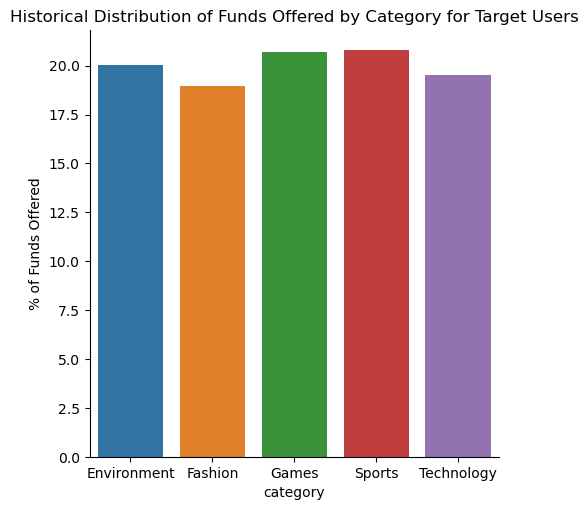

In [84]:
sns.catplot(total_fund_offer_by_category,x='category',y='% of Funds Offered',kind='bar').set(title='Historical Distribution of Funds Offered by Category for Target Users')

Thus, even though the target users are chosen to be similar to the best fund offerer of a given category, their funding history is not concentrated within a particular category. This indicates that the model has learnt associations between users exhibiting similar demographic and behavioral traits across categories